In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd())))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from src.data_prep import load_data, basic_clean
from src.features import build_patient_history
from src.modeling import make_preprocessor


In [6]:
import os
os.chdir(r"C:\Users\emira\Desktop\no_show_project")

df = load_data("data/raw/no_show_sample.csv")
df = basic_clean(df)
df = build_patient_history(df)
df.head()


c:\Users\emira\Desktop\no_show_project\src\features.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0.0)


,appointment_id,patient_id,scheduled_timestamp,appointment_timestamp,created_channel,department,doctor_id,age,sex,neighborhood,...,call_attempts_before,historical_noshow_rate_patient,past_appointments_patient,lead_time_days,recent_cancellations_patient,dow_hour,target_noshow,dow,hour,past_noshow_count
0,A1,P1,2025-10-01 09:00:00,2025-10-03 10:00:00,Online,Cardiology,D10,34,F,Central,...,0,0.0,0,2.041667,0,4_10,0,4,10,0.0
1,A2,P1,2025-10-10 09:00:00,2025-10-12 10:00:00,Online,Cardiology,D10,34,F,Central,...,0,0.0,1,2.041667,0,6_10,1,6,10,0.0
2,A3,P2,2025-10-02 10:00:00,2025-10-05 09:00:00,CallCenter,Neurology,D22,45,M,North,...,1,0.0,0,2.958333,0,6_9,0,6,9,0.0
3,A4,P3,2025-10-03 15:00:00,2025-10-04 09:00:00,Online,Dermatology,D30,29,F,East,...,0,0.0,0,0.750000,0,5_9,1,5,9,0.0
4,A5,P4,2025-10-04 09:00:00,2025-10-07 09:00:00,Onsite,Orthopedics,D40,55,M,West,...,1,0.0,0,3.000000,0,1_9,0,1,9,0.0


In [7]:
# Temel veri bilgileri
print("🔹 Veri Boyutu:", df.shape)
print("\n🔹 Sütunlar:")
print(df.columns.tolist())

# Eksik veri analizi
print("\n🔹 Eksik Değer Sayıları:")
print(df.isnull().sum())

# Sayısal sütunların özet istatistikleri
print("\n🔹 Temel İstatistikler:")
display(df.describe())

# Hedef değişken dağılımı (No-Show)
print("\n🔹 Hedef Değişken Dağılımı:")
display(df['target_noshow'].value_counts(normalize=True) * 100)


🔹 Veri Boyutu: (5, 22)

🔹 Sütunlar:
['appointment_id', 'patient_id', 'scheduled_timestamp', 'appointment_timestamp', 'created_channel', 'department', 'doctor_id', 'age', 'sex', 'neighborhood', 'insurance_type', 'sms_received_before', 'call_attempts_before', 'historical_noshow_rate_patient', 'past_appointments_patient', 'lead_time_days', 'recent_cancellations_patient', 'dow_hour', 'target_noshow', 'dow', 'hour', 'past_noshow_count']

🔹 Eksik Değer Sayıları:
appointment_id                    0
patient_id                        0
scheduled_timestamp               0
appointment_timestamp             0
created_channel                   0
department                        0
doctor_id                         0
age                               0
sex                               0
neighborhood                      0
insurance_type                    0
sms_received_before               0
call_attempts_before              0
historical_noshow_rate_patient    0
past_appointments_patient         0

,scheduled_timestamp,appointment_timestamp,age,sms_received_before,call_attempts_before,historical_noshow_rate_patient,past_appointments_patient,lead_time_days,recent_cancellations_patient,target_noshow,dow,hour,past_noshow_count
count,5,5,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.0
mean,2025-10-04 10:24:00,2025-10-06 14:12:00,39.400000,0.800000,0.400000,0.0,0.200000,2.158333,0.0,0.400000,4.400000,9.400000,0.0
min,2025-10-01 09:00:00,2025-10-03 10:00:00,29.000000,0.000000,0.000000,0.0,0.000000,0.750000,0.0,0.000000,1.000000,9.000000,0.0
25%,2025-10-02 10:00:00,2025-10-04 09:00:00,34.000000,1.000000,0.000000,0.0,0.000000,2.041667,0.0,0.000000,4.000000,9.000000,0.0
50%,2025-10-03 15:00:00,2025-10-05 09:00:00,34.000000,1.000000,0.000000,0.0,0.000000,2.041667,0.0,0.000000,5.000000,9.000000,0.0
75%,2025-10-04 09:00:00,2025-10-07 09:00:00,45.000000,1.000000,1.000000,0.0,0.000000,2.958333,0.0,1.000000,6.000000,10.000000,0.0
max,2025-10-10 09:00:00,2025-10-12 10:00:00,55.000000,1.000000,1.000000,0.0,1.000000,3.000000,0.0,1.000000,6.000000,10.000000,0.0
std,NaN,NaN,10.502381,0.447214,0.547723,0.0,0.447214,0.916383,0.0,0.547723,2.073644,0.547723,0.0



🔹 Hedef Değişken Dağılımı:


target_noshow
0    60.0
1    40.0
Name: proportion, dtype: float64

Veri boyutu: (5, 22)

Sütunlar: ['appointment_id', 'patient_id', 'scheduled_timestamp', 'appointment_timestamp', 'created_channel', 'department', 'doctor_id', 'age', 'sex', 'neighborhood', 'insurance_type', 'sms_received_before', 'call_attempts_before', 'historical_noshow_rate_patient', 'past_appointments_patient', 'lead_time_days', 'recent_cancellations_patient', 'dow_hour', 'target_noshow', 'dow', 'hour', 'past_noshow_count']


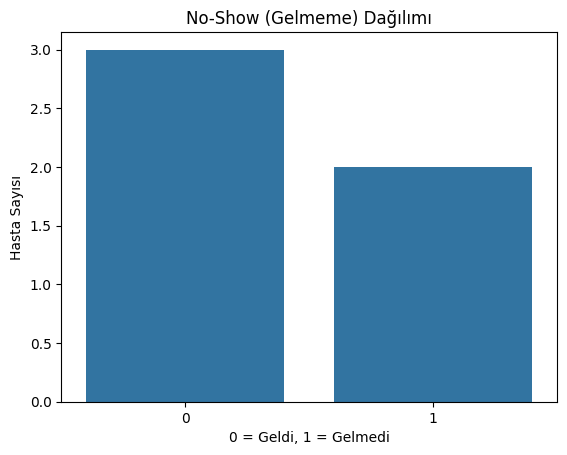

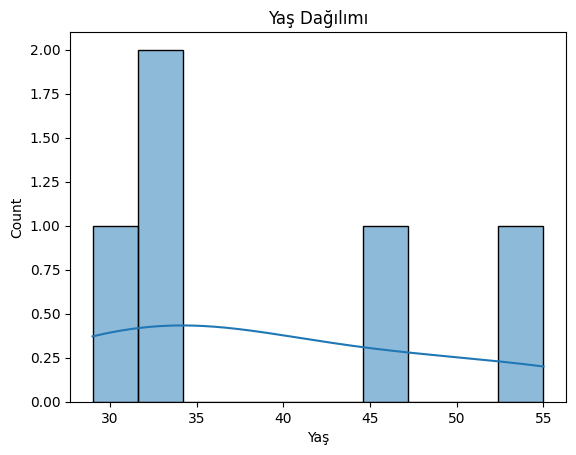

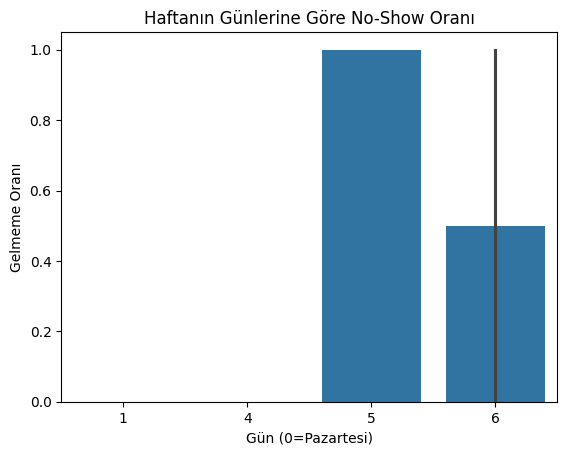

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Genel bilgi
print("Veri boyutu:", df.shape)
print("\nSütunlar:", df.columns.tolist())

# Hedef değişken dağılımı
sns.countplot(x="target_noshow", data=df)
plt.title("No-Show (Gelmeme) Dağılımı")
plt.xlabel("0 = Geldi, 1 = Gelmedi")
plt.ylabel("Hasta Sayısı")
plt.show()

# Yaş dağılımı
plt.figure()
sns.histplot(df["age"], bins=10, kde=True)
plt.title("Yaş Dağılımı")
plt.xlabel("Yaş")
plt.show()

# Gün bazlı no-show oranı
plt.figure()
sns.barplot(x="dow", y="target_noshow", data=df)
plt.title("Haftanın Günlerine Göre No-Show Oranı")
plt.xlabel("Gün (0=Pazartesi)")
plt.ylabel("Gelmeme Oranı")
plt.show()
